# 서울시 구로구 포트홀위치 예측
## RandomForestClassifier

### 공통 데이터 로드 & 전처리

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, precision_score, recall_score
from scipy.spatial.distance import cdist

# 데이터 파일 경로 설정
construction_sites_path = '서울특별시 구로구 민간공사장 현황_20221122_위경도추가.csv'
vehicle_data_path = '자동차등록현황보고_구로_필터링(201901 ~ 202410).csv'
potholes_data_path = 'grid_index_results.xlsx'
rainfall_data_path = '[기상청]서울시 강수량 데이터(2019년 ~ 2024년).csv'
temperature_data_path = '[기상청]서울시 기온 데이터(일교차 포함, 일별) (2019년 ~ 2024년).csv'
traffic_data_path = '구로구_교통량_데이터.csv'
snow_removal_path = '서울시 제설함 위치정보_구로_위도경도.xlsx'

# 데이터 로드
construction_sites_data = pd.read_csv(construction_sites_path, encoding='cp949')
vehicle_data = pd.read_csv(vehicle_data_path, encoding='cp949')
potholes_data = pd.read_excel(potholes_data_path)
rainfall_data = pd.read_csv(rainfall_data_path, encoding='cp949')
temperature_data = pd.read_csv(temperature_data_path, encoding='cp949')
traffic_data = pd.read_csv(traffic_data_path, encoding='cp949')
snow_removal_data = pd.read_excel(snow_removal_path)

# 날짜 열을 datetime 형식으로 변환
construction_sites_data['날짜'] = pd.to_datetime(construction_sites_data['날짜'], errors='coerce')
vehicle_data['날짜'] = pd.to_datetime(vehicle_data['날짜'], format='%Y-%m', errors='coerce')
potholes_data['발견일자'] = pd.to_datetime(potholes_data['발견일자'], errors='coerce')
rainfall_data['날짜'] = pd.to_datetime(rainfall_data['날짜'], errors='coerce')
temperature_data['날짜'] = pd.to_datetime(temperature_data['날짜'], errors='coerce')
traffic_data['날짜'] = pd.to_datetime(traffic_data['날짜'], errors='coerce')

# 숫자형 변환 및 결측값 처리
vehicle_data['화물총계'] = vehicle_data['화물총계'].replace(',', '', regex=True).astype(float)
snow_removal_data['위도'] = pd.to_numeric(snow_removal_data['위도'], errors='coerce')
snow_removal_data['경도'] = pd.to_numeric(snow_removal_data['경도'], errors='coerce')
construction_sites_data['위도'] = pd.to_numeric(construction_sites_data['위도'], errors='coerce')
construction_sites_data['경도'] = pd.to_numeric(construction_sites_data['경도'], errors='coerce')

# 결측값 제거
potholes_data = potholes_data.dropna(subset=['위도', '경도', '발견일자', 'grid_index']).reset_index(drop=True)
rainfall_data = rainfall_data.dropna(subset=['날짜']).reset_index(drop=True)
temperature_data = temperature_data.dropna(subset=['날짜', '일교차']).reset_index(drop=True)
traffic_data = traffic_data.dropna(subset=['날짜', '위도', '경도', '교통량']).reset_index(drop=True)
snow_removal_data = snow_removal_data.dropna(subset=['위도', '경도']).reset_index(drop=True)
construction_sites_data = construction_sites_data.dropna(subset=['위도', '경도', '날짜']).reset_index(drop=True)

# 포트홀 발견 이전 한 달간 데이터를 기반으로 특성 생성
pothole_prior_data = []
radius_threshold = 0.0045  # 약 500m

# 포트홀 좌표와 공사장, 제설함 좌표 배열
pothole_coords = potholes_data[['위도', '경도']].to_numpy()
construction_coords = construction_sites_data[['위도', '경도']].to_numpy()
snow_removal_coords = snow_removal_data[['위도', '경도']].to_numpy()

# 거리 계산 (공사장 및 제설함)
construction_distances = cdist(pothole_coords, construction_coords, metric='euclidean')
snow_removal_distances = cdist(pothole_coords, snow_removal_coords, metric='euclidean')

for idx, row in potholes_data.iterrows():
    start_date = row['발견일자'] - pd.Timedelta(days=30)
    end_date = row['발견일자']

    # 강수량 합계
    rainfall_prior = rainfall_data[(rainfall_data['날짜'] >= start_date) & (rainfall_data['날짜'] < end_date)]
    rainfall_total = rainfall_prior['강수량(mm)'].sum()

    # 평균 일교차
    temperature_prior = temperature_data[(temperature_data['날짜'] >= start_date) & (temperature_data['날짜'] < end_date)]
    avg_temperature_range = temperature_prior['일교차'].mean()

    # 가장 가까운 교통량 평균
    traffic_prior = traffic_data[(traffic_data['날짜'] >= start_date) & (traffic_data['날짜'] < end_date)]

    traffic_prior = traffic_prior.copy()
    if not traffic_prior.empty:
        traffic_prior['거리'] = np.sqrt((traffic_prior['위도'] - row['위도'])**2 +
                                        (traffic_prior['경도'] - row['경도'])**2)
        
        closest_traffic = traffic_prior.loc[traffic_prior['거리'].idxmin()]
        avg_traffic = closest_traffic['교통량']
    else:
        avg_traffic = 0

    # 화물총계
    vehicle_prior = vehicle_data[(vehicle_data['날짜'] >= start_date) & (vehicle_data['날짜'] < end_date)]
    total_freight_vehicles = vehicle_prior['화물총계'].sum()

    # 공사장 개수 및 제설함 개수
    construction_count = (construction_distances[idx] <= radius_threshold).sum()
    snow_removal_count = (snow_removal_distances[idx] <= radius_threshold).sum()

    
    pothole_prior_data.append({
        'grid_index': row['grid_index'],
        'row_index' : row['row_index'],
        'col_index' : row['col_index'],
        'DGM_NM' : row['DGM_NM'],
        '발견일자': row['발견일자'],
        '위도': row['위도'],
        '경도': row['경도'],
        '총강수량': rainfall_total,
        '평균일교차': avg_temperature_range,
        '평균교통량': avg_traffic,
        '화물총계': total_freight_vehicles,
        '공사장개수': construction_count,
        '제설함개수': snow_removal_count,
    })

In [3]:
# 통합 데이터프레임 생성
pothole_features_df = pd.DataFrame(pothole_prior_data)
pothole_features_df.fillna(0, inplace=True)  # 결측값 처리

pothole_features_df['grid_index'] = pothole_features_df['grid_index'].astype(int)
pothole_features_df['row_index'] = pothole_features_df['row_index'].astype(int)
pothole_features_df['col_index'] = pothole_features_df['col_index'].astype(int)

pothole_features_df

,grid_index,row_index,col_index,DGM_NM,발견일자,위도,경도,총강수량,평균일교차,평균교통량,화물총계,공사장개수,제설함개수
0,5216,49,82,중로1류,2019-01-02 00:00:00,37.482146,126.886898,0.0,7.600000,20479.0,144481.0,9,19
1,3060,35,48,기타도로시설,2019-01-02 00:00:00,37.491645,126.855979,0.0,7.600000,12374.0,144481.0,11,5
2,2223,17,35,소로2류,2019-01-02 00:00:00,37.504773,126.845058,0.0,7.600000,18582.0,144481.0,8,4
3,3060,35,48,기타도로시설,2019-01-02 13:48:24,37.491645,126.855979,0.0,8.300000,12374.0,144481.0,11,5
4,5280,50,83,소로2류,2019-01-02 14:05:24,37.481225,126.887546,0.0,8.300000,20479.0,144481.0,6,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9198,4854,2,77,기타도로시설,2024-10-28 20:49:39,37.515316,126.882293,74.0,8.813333,0.0,146584.0,0,1
9199,1552,39,24,기타도로시설,2024-10-29 03:09:00,37.489056,126.835196,74.0,8.646667,0.0,146584.0,4,9
9200,4182,23,66,기타도로시설,2024-10-29 03:12:53,37.500398,126.872350,74.0,8.646667,0.0,146584.0,17,10
9201,1291,30,20,기타도로시설,2024-10-29 10:37:20,37.495283,126.831369,74.0,8.646667,0.0,146584.0,10,6


### RandomForestClassifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# 특성과 타겟 분리
X = pothole_features_df[['총강수량', '평균일교차', '평균교통량', '화물총계', '공사장개수', '제설함개수', 'row_index', 'col_index']]
#X = pothole_features_df[['총강수량', '평균일교차', '평균교통량', '화물총계', '공사장개수', '제설함개수']]
y = pothole_features_df['grid_index']

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the grid positions
y_pred = model.predict(X_test)

In [7]:
X_test

,총강수량,평균일교차,평균교통량,화물총계,공사장개수,제설함개수,row_index,col_index
76,0.0,9.165517,18582.0,144481.0,10,16,27,39
5281,590.4,6.348276,3141.0,146402.0,4,12,32,29
2087,75.7,9.956667,19875.0,144526.0,0,5,22,50
582,80.6,11.270000,5595.0,143864.0,10,8,33,23
93,0.0,9.203333,22293.0,0.0,9,16,28,41
...,...,...,...,...,...,...,...,...
4112,34.7,8.980000,22247.0,145874.0,16,10,24,66
1659,9.1,8.326667,26235.0,143939.0,5,2,42,95
9096,143.0,7.760000,23889.0,146763.0,22,10,22,63
5573,13.6,8.146667,20113.0,148825.0,2,6,39,13


In [8]:
# Display actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nActual vs Predicted Values:\n", results)


Actual vs Predicted Values:
       Actual  Predicted
76      2485       2548
5281    1860       1860
2087    3173       3235
582     1483       1483
93      2612       2612
...      ...        ...
4112    4183       4183
1659    6028       6028
9096    3992       3992
5573     859        859
5700    2674       2674

[1841 rows x 2 columns]


In [9]:
# Evaluate the constrained predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Constrained): {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display predictions
print("Constrained Predictions:", y_pred)

Accuracy (Constrained): 0.92

Classification Report:
              precision    recall  f1-score   support

         249       1.00      0.67      0.80         3
         312       0.00      0.00      0.00         0
         373       1.00      1.00      1.00         4
         435       0.83      1.00      0.91         5
         437       1.00      1.00      1.00         1
         497       0.00      0.00      0.00         1
         498       1.00      1.00      1.00         2
         559       1.00      1.00      1.00         1
         603       0.00      0.00      0.00         1
         604       0.00      0.00      0.00         0
         608       0.00      0.00      0.00         1
         616       1.00      1.00      1.00         1
         666       0.00      0.00      0.00         1
         683       1.00      1.00      1.00        16
         722       1.00      1.00      1.00         1
         733       0.75      0.75      0.75         4
         745       1.00     

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classif

## RandomForestRegressor

In [10]:

# 특성과 타겟 분리
X = pothole_features_df[['총강수량', '평균일교차', '평균교통량', '화물총계', '공사장개수', '제설함개수', 'row_index', 'col_index']]
y = pothole_features_df['grid_index']

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 데이터셋 분리 (학습, 검증, 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성
model = RandomForestRegressor(random_state=42, n_estimators=100)

# 모델 학습
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

# 예측 결과를 정수로 변환
y_pred_int = np.round(y_pred).astype(int)

# Ensure predictions  fall within the range of target categories
y_pred_int = np.clip(y_pred_int, y.min(), y.max())


# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred_int)
r2 = r2_score(y_test, y_pred_int)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Display actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_int})
print("\nActual vs Predicted Values:\n", results)

# Calculate classification metrics
f1 = f1_score(y_test, y_pred_int, average='weighted')  # Adjust 'average' based on your need
precision = precision_score(y_test, y_pred_int, average='weighted')
recall = recall_score(y_test, y_pred_int, average='weighted')

# Display metrics
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Evaluate regression metrics
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error (MSE): 6.05214557305812
R-squared (R2): 0.9999973329442674

Actual vs Predicted Values:
       Actual  Predicted
76      2485       2484
5281    1860       1860
2087    3173       3172
582     1483       1483
93      2612       2612
...      ...        ...
4112    4183       4183
1659    6028       6028
9096    3992       3992
5573     859        859
5700    2674       2674

[1841 rows x 2 columns]
F1 Score: 0.9127372505291613
Precision: 0.9245727059469591
Recall: 0.9092884302009777
Mean Squared Error: 6.029401357957679


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_int})
print("\nActual vs Predicted Values:\n", results)

# 2. 테스트 데이터의 실제 값과 예측 값 출력
# 위도와 경도에 대한 실제 값과 예측 값을 데이터프레임으로 저장
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_int
}).reset_index(drop=True)

# 저장 경로 설정
test_results_output_path = 'test_results_lat_lon.xlsx'
test_results.to_excel(test_results_output_path, index=False)



Actual vs Predicted Values:
       Actual  Predicted
76      2485       2484
5281    1860       1860
2087    3173       3172
582     1483       1483
93      2612       2612
...      ...        ...
4112    4183       4183
1659    6028       6028
9096    3992       3992
5573     859        859
5700    2674       2674

[1841 rows x 2 columns]


### 테스트 데이터의 실제 값과 예측 값 비교

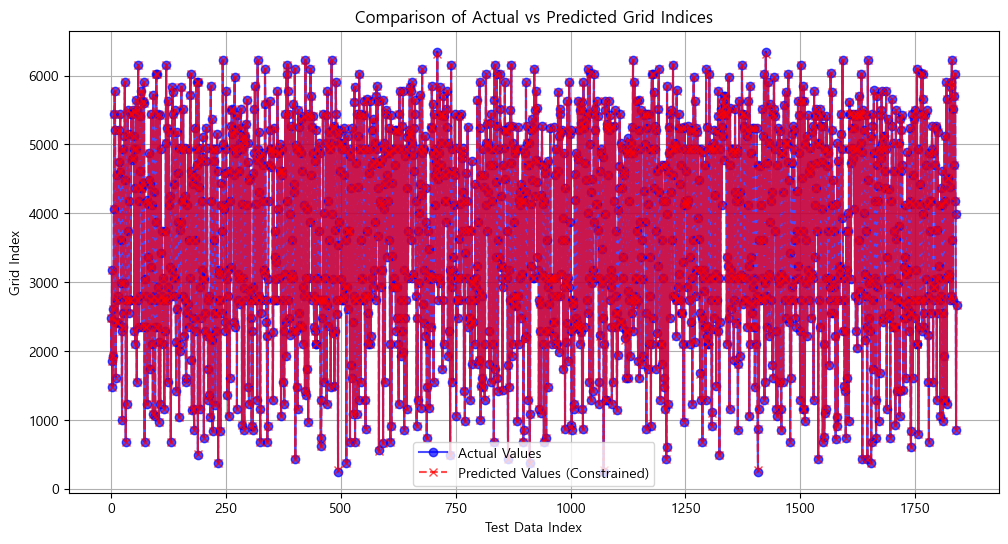

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic') # 한글 꺠짐 해결
#plt.rc('font', family='AppleGothic') # 한글 꺠짐 해결

plt.rcParams['axes.unicode_minus'] = False


# 실제 값과 예측 값을 비교하기 위해 테스트 데이터의 인덱스를 사용하여 비교 차트를 그립니다.
plt.figure(figsize=(12, 6))

# Plotting actual values from the test set
plt.plot(y_test.values, label='Actual Values', color='blue',  alpha=0.7,linestyle='-', marker='o')

# Plotting constrained predicted values
plt.plot(y_pred, label='Predicted Values (Constrained)', color='red',  alpha=0.7,linestyle='--', marker='x')

# Adding title and labels
plt.title('Comparison of Actual vs Predicted Grid Indices')
plt.xlabel('Test Data Index')
plt.ylabel('Grid Index')
plt.legend()

# Displaying the chart
plt.grid(True)
plt.show()


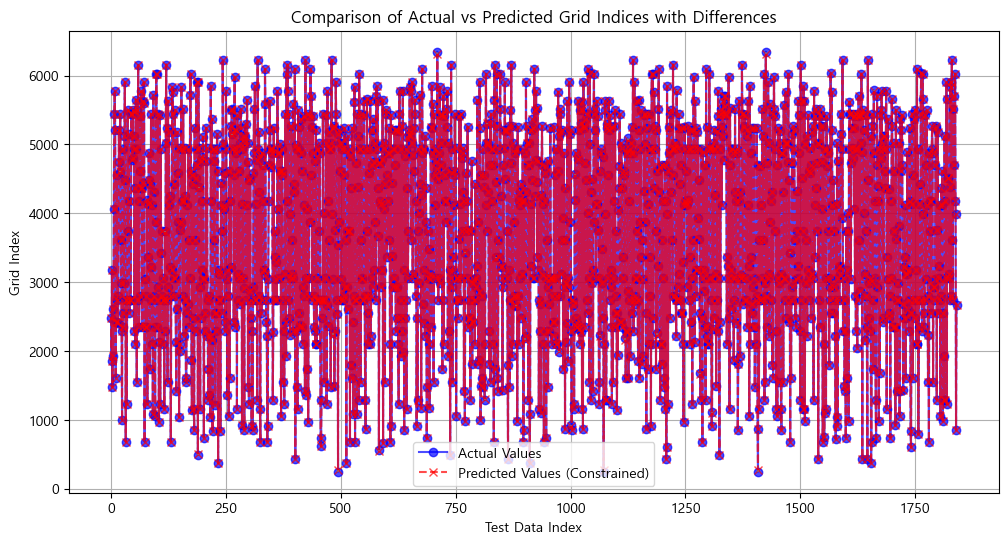

In [33]:
import matplotlib.pyplot as plt

# 차트에 예측 값과 실제 값의 차이를 선으로 연결하여 시각화
plt.figure(figsize=(12, 6))

# 실제 값 그리기
plt.plot(y_test.values, label='Actual Values', color='blue',  alpha=0.7,linestyle='-', marker='o')

# 예측 값 그리기
plt.plot(y_pred, label='Predicted Values (Constrained)', color='red',  alpha=0.7,linestyle='--', marker='x')

# 실제 값과 예측 값을 연결하는 선 그리기
for i in range(len(y_test)):
    plt.plot([i, i], [y_test.values[i], y_pred[i]], color='gray', linestyle='--', alpha=0.6)

# 타이틀 및 레이블 추가
plt.title('Comparison of Actual vs Predicted Grid Indices with Differences')
plt.xlabel('Test Data Index')
plt.ylabel('Grid Index')
plt.legend()

# 차트 표시
plt.grid(True)
plt.show()

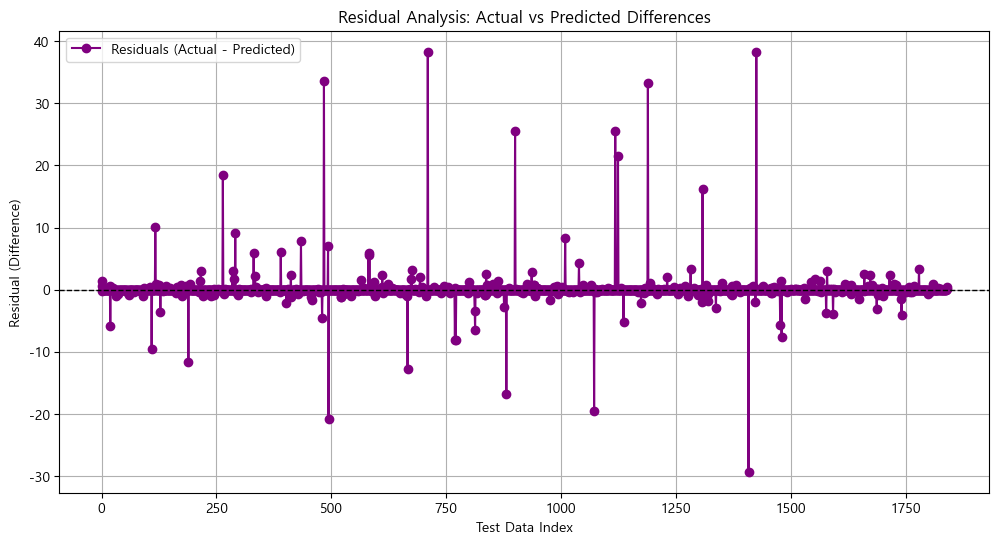

In [34]:
# 잔차(residual) 계산: 실제 값과 예측 값의 차이
residuals = y_test.values - y_pred

# 잔차 분석을 위한 시각화
plt.figure(figsize=(12, 6))

# 잔차 값 그리기
plt.plot(residuals, label='Residuals (Actual - Predicted)', color='purple', linestyle='-', marker='o')

# 타이틀 및 레이블 추가
plt.title('Residual Analysis: Actual vs Predicted Differences')
plt.xlabel('Test Data Index')
plt.ylabel('Residual (Difference)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # 기준선 (잔차가 0인 지점)
plt.legend()

# 차트 표시
plt.grid(True)
plt.show()


### 어느 요소가 포트홀 생성에 가장 많은 영향

6
6


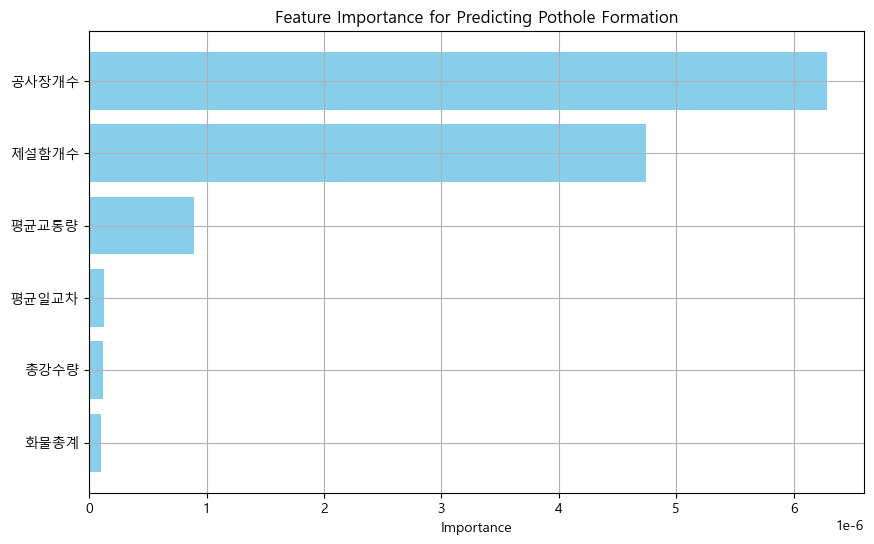

,Feature,Importance
4,공사장개수,6.286040e-06
5,제설함개수,4.742061e-06
2,평균교통량,8.904747e-07
1,평균일교차,1.284615e-07
0,총강수량,1.204172e-07
3,화물총계,1.055714e-07


In [50]:
# 'col_index'와 'row_index'를 제외한 특성만 선택
features = [col for col in X.columns if col not in ['col_index', 'row_index']]

# 특성 중요도 가져오기
# feature_importances 배열도 동일한 순서로 매핑되기 때문에 필요한 요소만 남김
reduced_importances = [
    importance for feature, importance in zip(X.columns, feature_importances)
    if feature not in ['col_index', 'row_index']
]

print(len(features))  # Feature 배열의 길이
print(len(reduced_importances))  # Feature Importances 배열의 길이

# 특성 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': reduced_importances
}).sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Predicting Pothole Formation')
plt.gca().invert_yaxis()  # 중요도 순으로 보기 위해 y축 뒤집기
plt.grid(True)
plt.show()

importance_df


### 데이터 세분화 및 계절 구분

In [14]:
# 계절 구분 함수 정의
def assign_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'  # 겨울
    elif month in [3, 4, 5]:
        return 'Spring'  # 봄
    elif month in [6, 7, 8]:
        return 'Summer'  # 여름
    elif month in [9, 10, 11]:
        return 'Autumn'  # 가을

# 교통량 데이터에 시간대별 및 계절 추가
traffic_data['season'] = traffic_data['날짜'].apply(assign_season)  # 계절 추가

# 전체 데이터를 계절로 나누기
pothole_features_df['season'] = pothole_features_df['발견일자'].apply(assign_season)

# 데이터 확인
seasonal_overview = {
    "pothole_data_with_season": pothole_features_df[['발견일자', 'season']].head()
}

seasonal_overview


{'pothole_data_with_season':                  발견일자  season
 0 2019-01-02 00:00:00  Winter
 1 2019-01-02 00:00:00  Winter
 2 2019-01-02 00:00:00  Winter
 3 2019-01-02 13:48:24  Winter
 4 2019-01-02 14:05:24  Winter}

### 분석: 계절별 특성 중요도

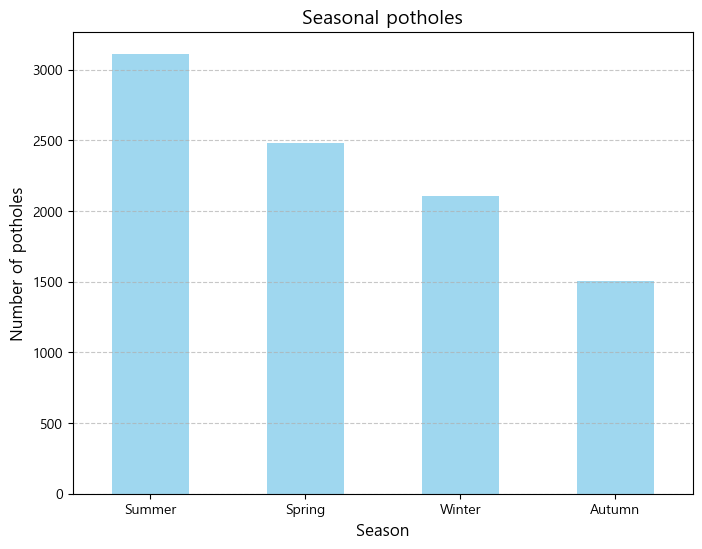

{'seasonal_pothole_counts': season
 Summer    3113
 Spring    2483
 Winter    2104
 Autumn    1503
 Name: count, dtype: int64}

In [55]:
# 계절별 포트홀 발생 데이터 요약
seasonal_pothole_counts = pothole_features_df['season'].value_counts()

# 계절별 포트홀 발생 데이터 시각화
plt.figure(figsize=(8, 6))
seasonal_pothole_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Seasonal potholes', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of potholes', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 데이터 확인
{
    "seasonal_pothole_counts": seasonal_pothole_counts
}


### 월별 포트홀 발생

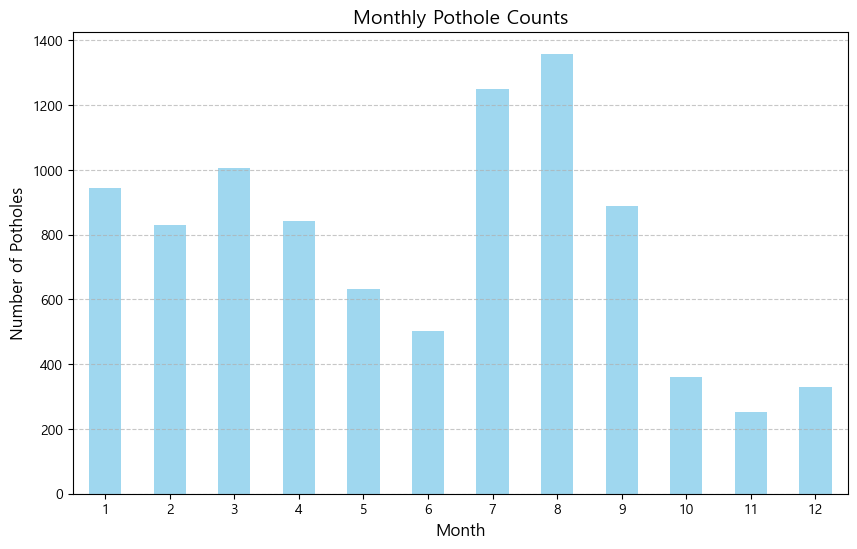

발견일자
1      944
2      831
3     1007
4      843
5      633
6      503
7     1251
8     1359
9      890
10     361
11     252
12     329
Name: count, dtype: int64

In [56]:
# 월별 포트홀 발생 데이터 요약
monthly_pothole_counts = pothole_features_df['발견일자'].dt.month.value_counts().sort_index()

# 월별 포트홀 발생 데이터 시각화
plt.figure(figsize=(10, 6))
monthly_pothole_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Monthly Pothole Counts', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Potholes', fontsize=12)
plt.xticks(ticks=range(0, 12), labels=[str(i + 1) for i in range(12)], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 데이터 확인
monthly_pothole_counts

### 전월 대비 변수 변화율과 포트홀 변화율

#### 이 분석은 앞서 진행한 교통량 증가가 포트홀 증가에 영향을 많이 준다는 결과와 반대로 나와서 버려야 할 것 같습니다

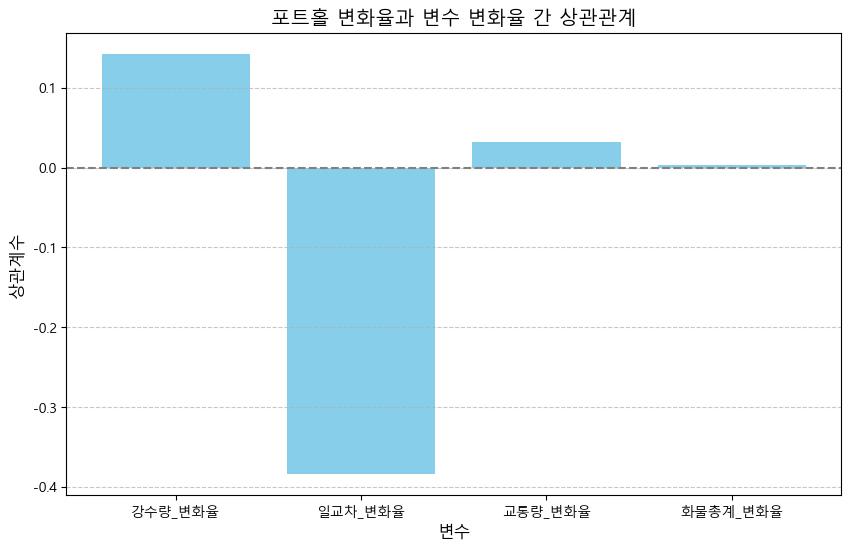

,변수,포트홀 변화율 상관계수
0,강수량_변화율,0.142521
2,교통량_변화율,0.032113
3,화물총계_변화율,0.003056
1,일교차_변화율,-0.383702


In [57]:
# 월별 데이터를 집계하기 위해 '발견일자'와 '날짜'에서 월 추출
potholes_data['월'] = potholes_data['발견일자'].dt.to_period('M')
rainfall_data['월'] = rainfall_data['날짜'].dt.to_period('M')
temperature_data['월'] = temperature_data['날짜'].dt.to_period('M')
traffic_data['월'] = traffic_data['날짜'].dt.to_period('M')
vehicle_data['월'] = vehicle_data['날짜'].dt.to_period('M')

# 월별 데이터 집계
monthly_potholes = potholes_data.groupby('월').size().rename('포트홀개수')
monthly_rainfall = rainfall_data.groupby('월')['강수량(mm)'].sum()
monthly_temperature = temperature_data.groupby('월')['일교차'].mean()
monthly_traffic = traffic_data.groupby('월')['교통량'].sum()
monthly_vehicles = vehicle_data.groupby('월')['화물총계'].sum()

# 데이터프레임 통합
monthly_data = pd.concat([monthly_potholes, monthly_rainfall, monthly_temperature, monthly_traffic, monthly_vehicles], axis=1).dropna()

# 전월 대비 변화율 계산
monthly_data_diff = monthly_data.pct_change().dropna()  # 전월 대비 변화율 계산
monthly_data_diff.rename(columns={
    '강수량(mm)': '강수량_변화율',
    '일교차': '일교차_변화율',
    '교통량': '교통량_변화율',
    '화물총계': '화물총계_변화율',
    '포트홀개수': '포트홀개수_변화율'
}, inplace=True)

# 상관관계 분석
correlation_with_potholes = monthly_data_diff.corr()['포트홀개수_변화율'].drop('포트홀개수_변화율')

# 분석 결과 데이터프레임 생성
correlation_results = correlation_with_potholes.reset_index()
correlation_results.columns = ['변수', '포트홀 변화율 상관계수']

# 상관계수 시각화
plt.figure(figsize=(10, 6))
plt.bar(correlation_results['변수'], correlation_results['포트홀 변화율 상관계수'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('포트홀 변화율과 변수 변화율 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 상관계수 결과 데이터프레임 미리보기
correlation_results.sort_values(by='포트홀 변화율 상관계수', ascending=False)

### 전월 대비 변수 '증가'율과 포트홀 '증가율'

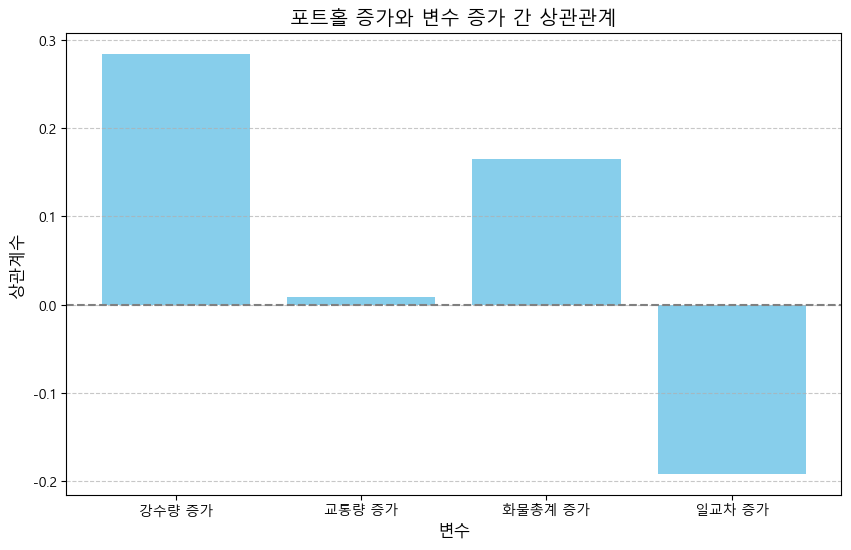

,변수,포트홀 증가와의 상관계수
0,강수량 증가,0.284567
2,화물총계 증가,0.165031
1,교통량 증가,0.009001
3,일교차 증가,-0.191414


In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 월별 데이터 집계
potholes_data['월'] = potholes_data['발견일자'].dt.to_period('M')
rainfall_data['월'] = rainfall_data['날짜'].dt.to_period('M')
temperature_data['월'] = temperature_data['날짜'].dt.to_period('M')
traffic_data['월'] = traffic_data['날짜'].dt.to_period('M')
vehicle_data['월'] = vehicle_data['날짜'].dt.to_period('M')

monthly_potholes = potholes_data.groupby('월').size().rename('포트홀개수')
monthly_rainfall = rainfall_data.groupby('월')['강수량(mm)'].sum()
monthly_temperature = temperature_data.groupby('월')['일교차'].mean()
monthly_traffic = traffic_data.groupby('월')['교통량'].sum()
monthly_vehicles = vehicle_data.groupby('월')['화물총계'].sum()

# 데이터프레임 통합
monthly_data = pd.concat([monthly_potholes, monthly_rainfall, monthly_temperature, monthly_traffic, monthly_vehicles], axis=1).dropna()

# 각 변수의 증가 여부 계산
monthly_data['포트홀 증가'] = monthly_data['포트홀개수'].diff() > 0
monthly_data['강수량 증가'] = monthly_data['강수량(mm)'].diff() > 0
monthly_data['교통량 증가'] = monthly_data['교통량'].diff() > 0
monthly_data['화물총계 증가'] = monthly_data['화물총계'].diff() > 0
monthly_data['일교차 증가'] = monthly_data['일교차'].diff() > 0

# 변수 증가가 포트홀 증가에 미치는 영향 분석
correlation_results = monthly_data[['포트홀 증가', '강수량 증가', '교통량 증가', '화물총계 증가', '일교차 증가']].corr()['포트홀 증가'].drop('포트홀 증가')

# 분석 결과 데이터프레임 생성
correlation_results_df = correlation_results.reset_index()
correlation_results_df.columns = ['변수', '포트홀 증가와의 상관계수']

# 상관계수 시각화
plt.figure(figsize=(10, 6))
plt.bar(correlation_results_df['변수'], correlation_results_df['포트홀 증가와의 상관계수'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('포트홀 증가와 변수 증가 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 상관계수 결과 데이터프레임 미리보기
correlation_results_df.sort_values(by='포트홀 증가와의 상관계수', ascending=False)


#### 강수량과 일교차의 복합 효과를 분석하여 상관관계의 잠재적 원인을 탐구.

                            OLS Regression Results                            
Dep. Variable:             grid_index   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     18.63
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           4.79e-12
Time:                        00:48:26   Log-Likelihood:                -80288.
No. Observations:                9203   AIC:                         1.606e+05
Df Residuals:                    9199   BIC:                         1.606e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3830.1483    145.082     26.400   

<Figure size 1200x800 with 0 Axes>

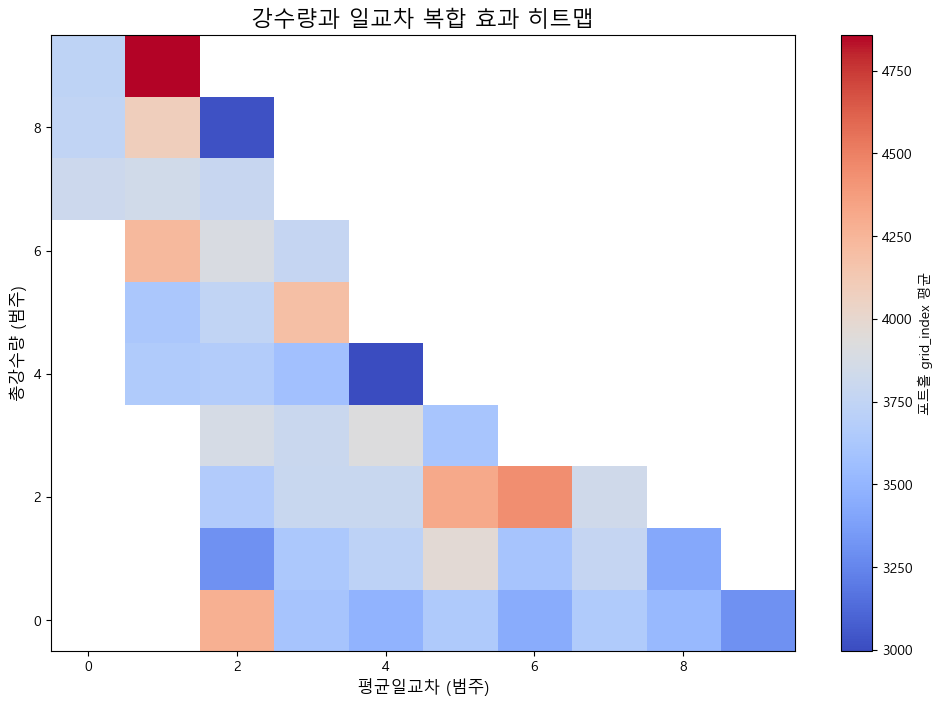

In [64]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 생성된 pothole_prior_data를 DataFrame으로 변환
pothole_features_df = pd.DataFrame(pothole_prior_data)

# 결측값 처리
pothole_features_df.fillna(0, inplace=True)

# 상호작용 변수 생성
pothole_features_df['강수량_일교차_상호작용'] = (
    pothole_features_df['총강수량'] * pothole_features_df['평균일교차']
)

# 독립 변수(X)와 종속 변수(y) 정의
X = pothole_features_df[['총강수량', '평균일교차', '강수량_일교차_상호작용']]
y = pothole_features_df['grid_index']  # 예를 들어, 포트홀 발생 위치를 종속 변수로 사용

# 상수항 추가 (회귀 모델에 필요)
X = sm.add_constant(X)

# 다중 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 출력
print(model.summary())

# 강수량과 일교차 복합 효과 시각화
plt.figure(figsize=(12, 8))

# 연속형 변수를 범주형으로 변환
pothole_features_df['총강수량_범주'] = pd.cut(pothole_features_df['총강수량'], bins=10, labels=False)
pothole_features_df['평균일교차_범주'] = pd.cut(pothole_features_df['평균일교차'], bins=10, labels=False)

# 히트맵 데이터 생성
interaction = pothole_features_df.pivot_table(
    values='grid_index', 
    index='총강수량_범주', 
    columns='평균일교차_범주', 
    aggfunc='mean'
)

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(interaction, cmap='coolwarm', aspect='auto', origin='lower')
plt.colorbar(label='포트홀 grid_index 평균')
plt.title('강수량과 일교차 복합 효과 히트맵', fontsize=16)
plt.xlabel('평균일교차 (범주)', fontsize=12)
plt.ylabel('총강수량 (범주)', fontsize=12)
plt.grid(False)
plt.show()

### 전년대비 변수 변화율과 포트홀 변화율

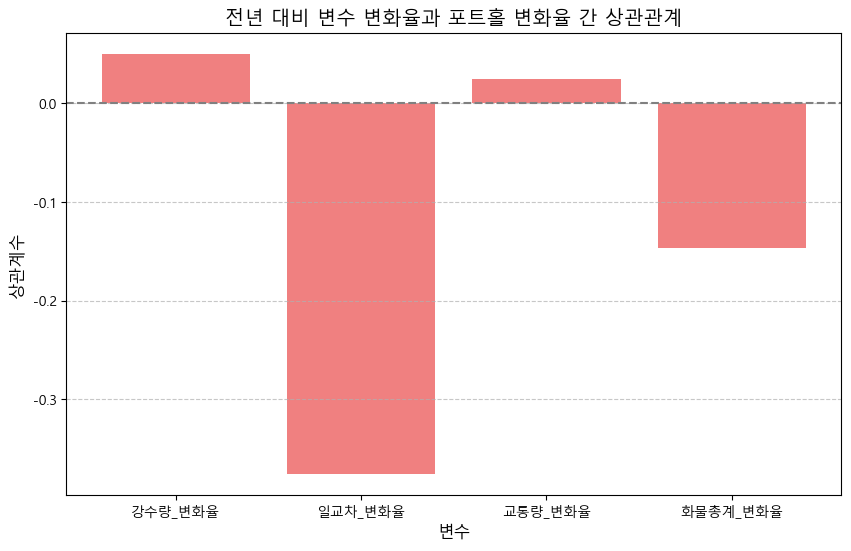

,변수,포트홀 변화율 상관계수
0,강수량_변화율,0.050152
2,교통량_변화율,0.024834
3,화물총계_변화율,-0.146281
1,일교차_변화율,-0.375420


In [66]:
# 전년 대비 변화를 계산하기 위해 데이터의 연도-월 단위 그룹화
monthly_potholes = potholes_data.groupby('월').size().rename('포트홀개수')
monthly_rainfall = rainfall_data.groupby('월')['강수량(mm)'].sum()
monthly_temperature = temperature_data.groupby('월')['일교차'].mean()
monthly_traffic = traffic_data.groupby('월')['교통량'].mean()
monthly_vehicles = vehicle_data.groupby('월')['화물총계'].sum()

# 데이터 통합
yearly_data = pd.concat(
    [monthly_potholes, monthly_rainfall, monthly_temperature, monthly_traffic, monthly_vehicles], axis=1
).dropna()

# 전년 대비 변화율 계산
yearly_data_diff = yearly_data.pct_change(12).dropna()  # 전년 대비 변화율 계산
yearly_data_diff.rename(columns={
    '강수량(mm)': '강수량_변화율',
    '일교차': '일교차_변화율',
    '교통량': '교통량_변화율',
    '화물총계': '화물총계_변화율',
    '포트홀개수': '포트홀개수_변화율'
}, inplace=True)

# 포트홀 변화율과 각 변수 변화율 간의 상관분석
correlation_with_potholes_yearly = yearly_data_diff.corr()['포트홀개수_변화율'].drop('포트홀개수_변화율')

# 결과 정리
correlation_results_yearly = correlation_with_potholes_yearly.reset_index()
correlation_results_yearly.columns = ['변수', '포트홀 변화율 상관계수']

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(correlation_results_yearly['변수'], correlation_results_yearly['포트홀 변화율 상관계수'], color='lightcoral')
plt.axhline(0, color='gray', linestyle='--')
plt.title('전년 대비 변수 변화율과 포트홀 변화율 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 결과 데이터프레임 미리보기
correlation_results_yearly.sort_values(by='포트홀 변화율 상관계수', ascending=False)


### 전년 대비 변수 '증가율'과 포트홀 '증가율'

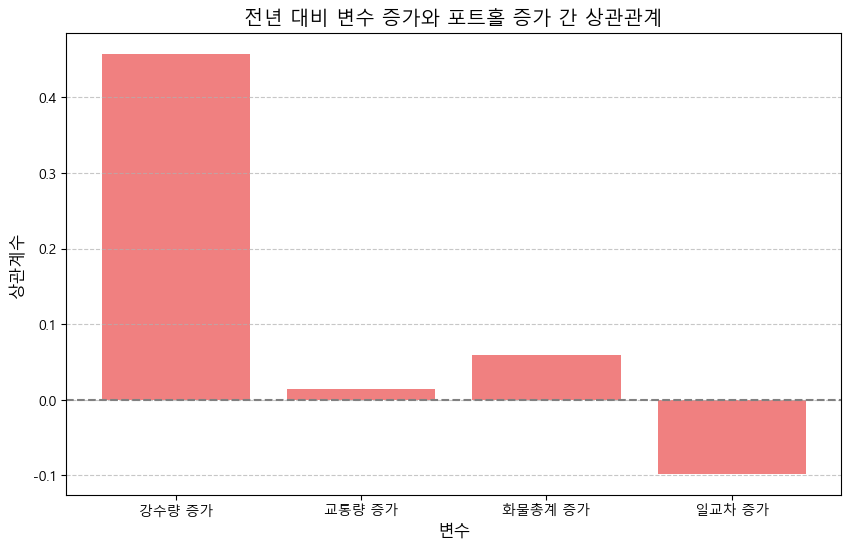

,변수,포트홀 증가와의 상관계수
0,강수량 증가,0.458079
2,화물총계 증가,0.059675
1,교통량 증가,0.014200
3,일교차 증가,-0.097654


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# 월별 데이터 집계
monthly_potholes = potholes_data.groupby('월').size().rename('포트홀개수')
monthly_rainfall = rainfall_data.groupby('월')['강수량(mm)'].sum()
monthly_temperature = temperature_data.groupby('월')['일교차'].mean()
monthly_traffic = traffic_data.groupby('월')['교통량'].mean()
monthly_vehicles = vehicle_data.groupby('월')['화물총계'].sum()

# 데이터 통합
yearly_data = pd.concat(
    [monthly_potholes, monthly_rainfall, monthly_temperature, monthly_traffic, monthly_vehicles], axis=1
).dropna()

# 데이터 증가 여부 계산
yearly_data['포트홀 증가'] = yearly_data['포트홀개수'].diff(12) > 0  # 전년 대비 증가 여부
yearly_data['강수량 증가'] = yearly_data['강수량(mm)'].diff(12) > 0
yearly_data['교통량 증가'] = yearly_data['교통량'].diff(12) > 0
yearly_data['화물총계 증가'] = yearly_data['화물총계'].diff(12) > 0
yearly_data['일교차 증가'] = yearly_data['일교차'].diff(12) > 0

# 변수 증가 여부와 포트홀 증가 여부 간 상관관계 계산
correlation_results_yearly = yearly_data[
    ['포트홀 증가', '강수량 증가', '교통량 증가', '화물총계 증가', '일교차 증가']
].corr()['포트홀 증가'].drop('포트홀 증가')

# 결과 정리
correlation_results_df = correlation_results_yearly.reset_index()
correlation_results_df.columns = ['변수', '포트홀 증가와의 상관계수']

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(correlation_results_df['변수'], correlation_results_df['포트홀 증가와의 상관계수'], color='lightcoral')
plt.axhline(0, color='gray', linestyle='--')
plt.title('전년 대비 변수 증가와 포트홀 증가 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 결과 데이터프레임 미리보기
correlation_results_df.sort_values(by='포트홀 증가와의 상관계수', ascending=False)


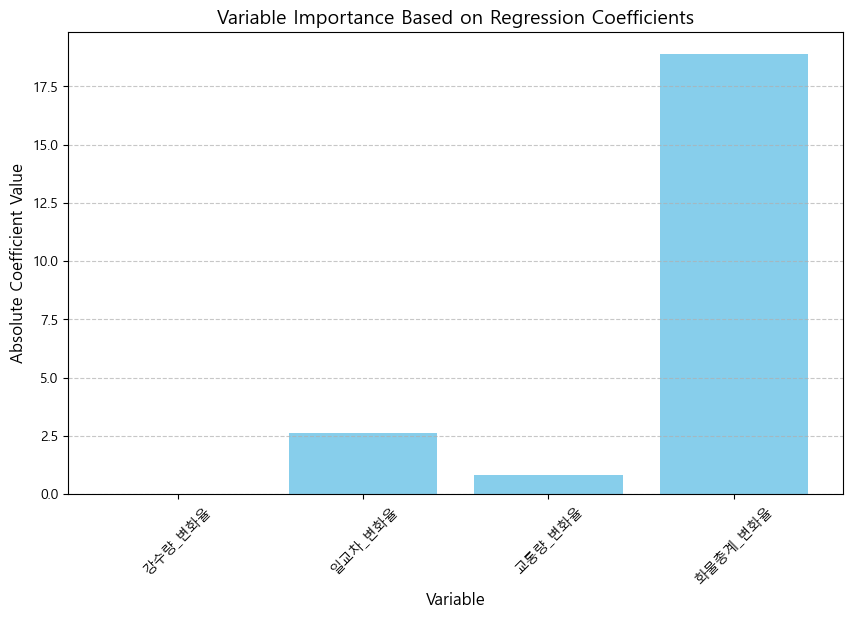

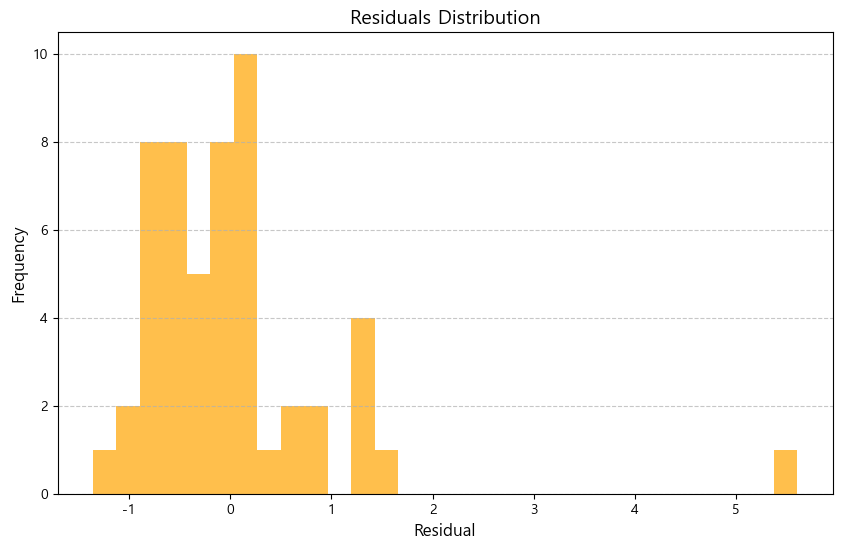

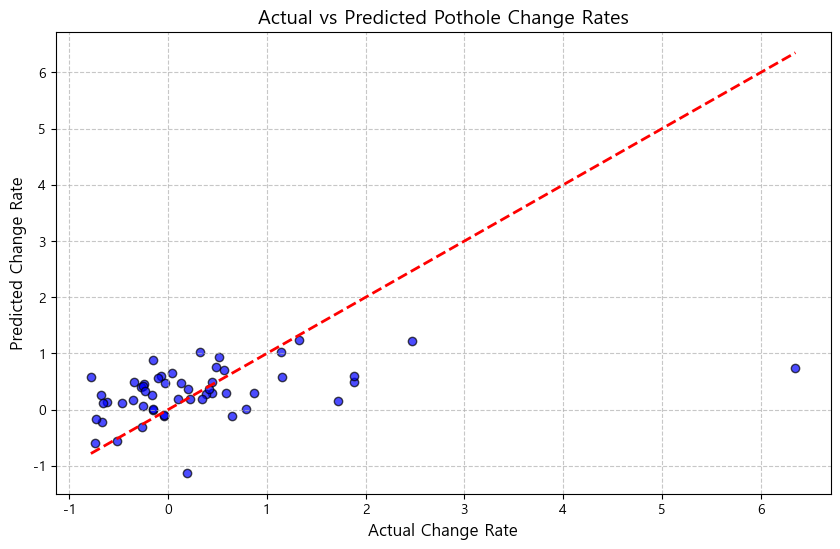

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              포트홀개수_변화율   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.279
Date:                Sun, 01 Dec 2024   Prob (F-statistic):             0.0744
Time:                        00:19:17   Log-Likelihood:                -75.725
No. Observations:                  53   AIC:                             161.5
Df Residuals:                      48   BIC:                             171.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4186      0.172      2.435      0.019       0.073       0.764
강수량_변화율       -0.0074      0.043     -0.172      0.864      -0.095       0.080
일교차_변화율       -2.6246      1.100     -2.386      0.021      -4.837      -0.413
교통량_변화율        0.8045      1.011      0.796      0.430      -1.228       2.837
화물총계_변화율     -18.8852     17.645     -1.070      0.290     -54.363      16.593
==============================================================================
Omnibus:                       67.005   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.891
Skew:                           3.318   Prob(JB):                    9.08e-136
Kurtosis:                      18.413   Cond. No.                         486.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic') # 한글 꺠짐 해결
plt.rcParams['axes.unicode_minus'] = False #마이너스 깨짐 해결

# Assuming `yearly_data_diff` has been created with relevant data
# This contains '강수량_변화율', '일교차_변화율', '교통량_변화율', '화물총계_변화율', and '포트홀개수_변화율'

# Step 1: Data Preparation - Handle NaN and Inf values
X = yearly_data_diff[['강수량_변화율', '일교차_변화율', '교통량_변화율', '화물총계_변화율']]
y = yearly_data_diff['포트홀개수_변화율']

# Clean the data
X_cleaned = X.replace([np.inf, -np.inf], np.nan).dropna()
y_cleaned = y.loc[X_cleaned.index]  # Ensure y matches X_cleaned's index

# Step 2: Add constant for statsmodels
X_with_const_cleaned = sm.add_constant(X_cleaned)

# Step 3: Perform Regression Analysis with statsmodels
model_cleaned = sm.OLS(y_cleaned, X_with_const_cleaned).fit()

# Step 4: Perform Regression Analysis with sklearn
linear_model_cleaned = LinearRegression()
linear_model_cleaned.fit(X_cleaned, y_cleaned)

# Coefficients from sklearn
coefficients_cleaned = pd.DataFrame({
    'Variable': X_cleaned.columns,
    'Coefficient': linear_model_cleaned.coef_
})
coefficients_cleaned['abs_coefficient'] = coefficients_cleaned['Coefficient'].abs()

# Step 5: Visualization - Variable Importance
plt.figure(figsize=(10, 6))
plt.bar(coefficients_cleaned['Variable'], coefficients_cleaned['abs_coefficient'], color='skyblue')
plt.title('Variable Importance Based on Regression Coefficients', fontsize=14)
plt.xlabel('Variable', fontsize=12)
plt.ylabel('Absolute Coefficient Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# Step 6: Residual Analysis
y_pred_cleaned = linear_model_cleaned.predict(X_cleaned)
residuals = y_cleaned - y_pred_cleaned

# Residual Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='orange')
plt.title('Residuals Distribution', fontsize=14)
plt.xlabel('Residual', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 7: Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_cleaned, y_pred_cleaned, alpha=0.7, color='blue', edgecolors='k')
plt.plot([y_cleaned.min(), y_cleaned.max()], [y_cleaned.min(), y_cleaned.max()], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Pothole Change Rates', fontsize=14)
plt.xlabel('Actual Change Rate', fontsize=12)
plt.ylabel('Predicted Change Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 8: Display Regression Summary
model_cleaned_summary = model_cleaned.summary()
model_cleaned_summary

### 강수량, 일교차, 교통량 데이터를 월별로 결합하여 포트홀 발생 증가 요인을 심층 분석

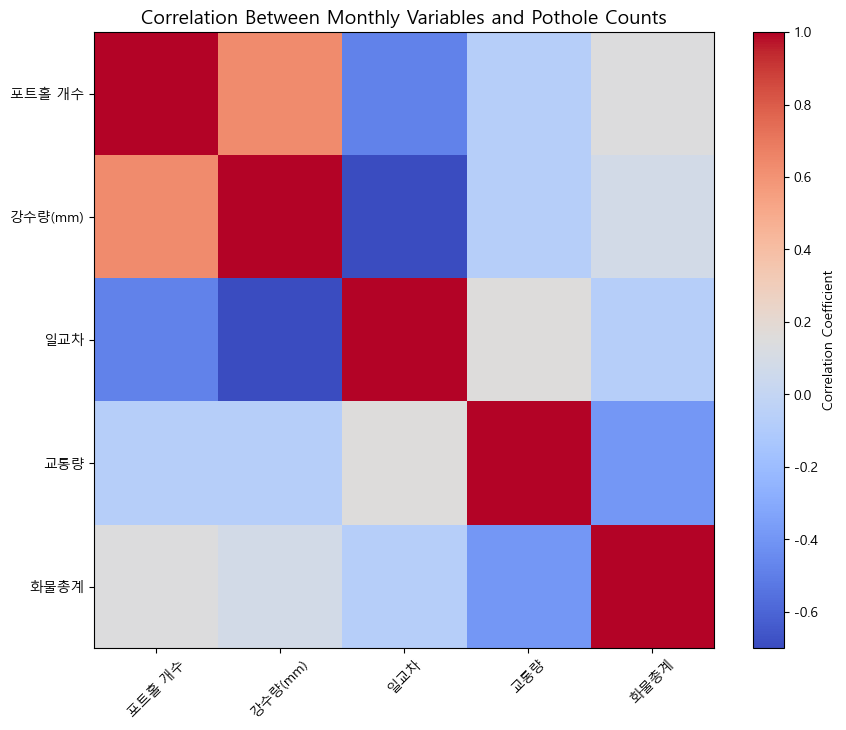

,포트홀 개수,강수량(mm),일교차,교통량,화물총계
포트홀 개수,1.000000,0.634463,-0.485479,-0.074827,0.147085
강수량(mm),0.634463,1.000000,-0.700377,-0.071033,0.088150
일교차,-0.485479,-0.700377,1.000000,0.150180,-0.074455
교통량,-0.074827,-0.071033,0.150180,1.000000,-0.390034
화물총계,0.147085,0.088150,-0.074455,-0.390034,1.000000


In [69]:
# 강수량, 일교차, 교통량 데이터에서 월별 집계 생성
monthly_rainfall = rainfall_data.groupby(rainfall_data['날짜'].dt.to_period('M'))['강수량(mm)'].sum()
monthly_temperature = temperature_data.groupby(temperature_data['날짜'].dt.to_period('M'))['일교차'].mean()
monthly_traffic = traffic_data.groupby(traffic_data['날짜'].dt.to_period('M'))['교통량'].mean()
monthly_vehicles = vehicle_data.groupby(vehicle_data['날짜'].dt.to_period('M'))['화물총계'].sum()

# 포트홀 발생 수 월별 집계
monthly_pothole_counts = potholes_data.groupby(potholes_data['발견일자'].dt.to_period('M')).size().rename('포트홀 개수')

# 데이터 결합
monthly_analysis_df = pd.concat([
    monthly_pothole_counts, 
    monthly_rainfall, 
    monthly_temperature, 
    monthly_traffic,
    monthly_vehicles
], axis=1).dropna()

# 상관관계 분석
correlation_analysis = monthly_analysis_df.corr()

# 상관계수 시각화
plt.figure(figsize=(10, 8))
plt.imshow(correlation_analysis, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_analysis.columns)), correlation_analysis.columns, rotation=45)
plt.yticks(range(len(correlation_analysis.index)), correlation_analysis.index)
plt.title('Correlation Between Monthly Variables and Pothole Counts', fontsize=14)
plt.grid(False)
plt.show()

# 상관계수 데이터프레임 출력
correlation_analysis

/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_74379/4116756994.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(monthly_analysis_df['Month'], rotation=45)


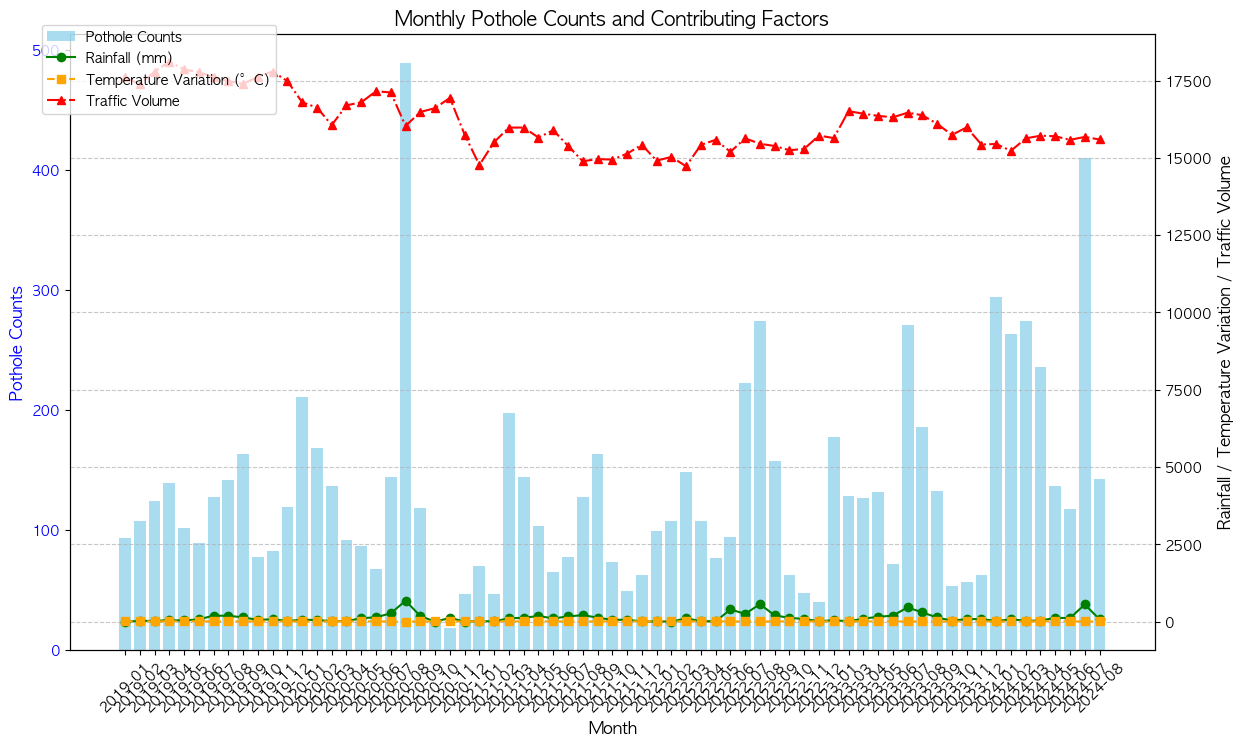

In [310]:
# 월별 데이터를 정리하여 시각화
monthly_analysis_df.reset_index(inplace=True)
monthly_analysis_df.rename(columns={'index': 'Month'}, inplace=True)
monthly_analysis_df['Month'] = monthly_analysis_df['Month'].astype(str)

# 강수량, 일교차, 교통량, 포트홀 발생을 하나의 시각화에 표현
fig, ax1 = plt.subplots(figsize=(14, 8))

# 포트홀 발생 수 (Bar Plot)
ax1.bar(monthly_analysis_df['Month'], monthly_analysis_df['포트홀 개수'], color='skyblue', alpha=0.7, label='Pothole Counts')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Pothole Counts', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(monthly_analysis_df['Month'], rotation=45)

# 강수량, 일교차, 교통량 (Line Plot)
ax2 = ax1.twinx()
ax2.plot(monthly_analysis_df['Month'], monthly_analysis_df['강수량(mm)'], label='Rainfall (mm)', color='green', linestyle='-', marker='o')
ax2.plot(monthly_analysis_df['Month'], monthly_analysis_df['일교차'], label='Temperature Variation (°C)', color='orange', linestyle='--', marker='s')
ax2.plot(monthly_analysis_df['Month'], monthly_analysis_df['교통량'], label='Traffic Volume', color='red', linestyle='-.', marker='^')
ax2.set_ylabel('Rainfall / Temperature Variation / Traffic Volume', fontsize=12)
ax2.tick_params(axis='y')

# 범례 추가
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=10)
plt.title('Monthly Pothole Counts and Contributing Factors', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
import pandas as pd

# 파일 경로 설정
file_path_snow = '/mnt/data/서울시 제설함 위치정보.csv'
file_path_salt = '/mnt/data/서울시 염화칼슘보관함 위치정보.csv'

# 1. 데이터 불러오기
snow_data = pd.read_csv(file_path_snow)
salt_data = pd.read_csv(file_path_salt)

# 2. 데이터 정제
# 열 이름 확인 및 통일 (예: '주소'와 같은 열이 동일한지 확인)
print("제설함 데이터 열:", snow_data.columns)
print("염화칼슘 데이터 열:", salt_data.columns)

# 열 이름 정리 (예: '주소'와 '위치'를 동일한 이름으로 통일)
snow_data.rename(columns={'주소': 'Location'}, inplace=True)
salt_data.rename(columns={'주소': 'Location'}, inplace=True)

# 3. 데이터 병합
# 데이터 병합: Location을 기준으로 Outer Join
merged_data = pd.concat([snow_data, salt_data], ignore_index=True)

# 4. 특정 행정구역(구로구) 필터링
merged_data = merged_data[merged_data['Location'].str.contains('구로구', na=False)]

# 5. 결측치 처리: 위도(Latitude)와 경도(Longitude)가 없는 데이터 제거
cleaned_data = merged_data.dropna(subset=['Latitude', 'Longitude'])

# 6. 불필요한 열 제거
columns_to_keep = ['Location', 'Latitude', 'Longitude']  # 필요한 열만 남김
cleaned_data = cleaned_data[columns_to_keep]

# 7. 데이터 정렬
cleaned_data = cleaned_data.sort_values(by='Location').reset_index(drop=True)

# 8. 결과 저장
cleaned_data.to_csv(output_path, index=False)

print(f"정제된 데이터가 {output_path}에 저장되었습니다.")


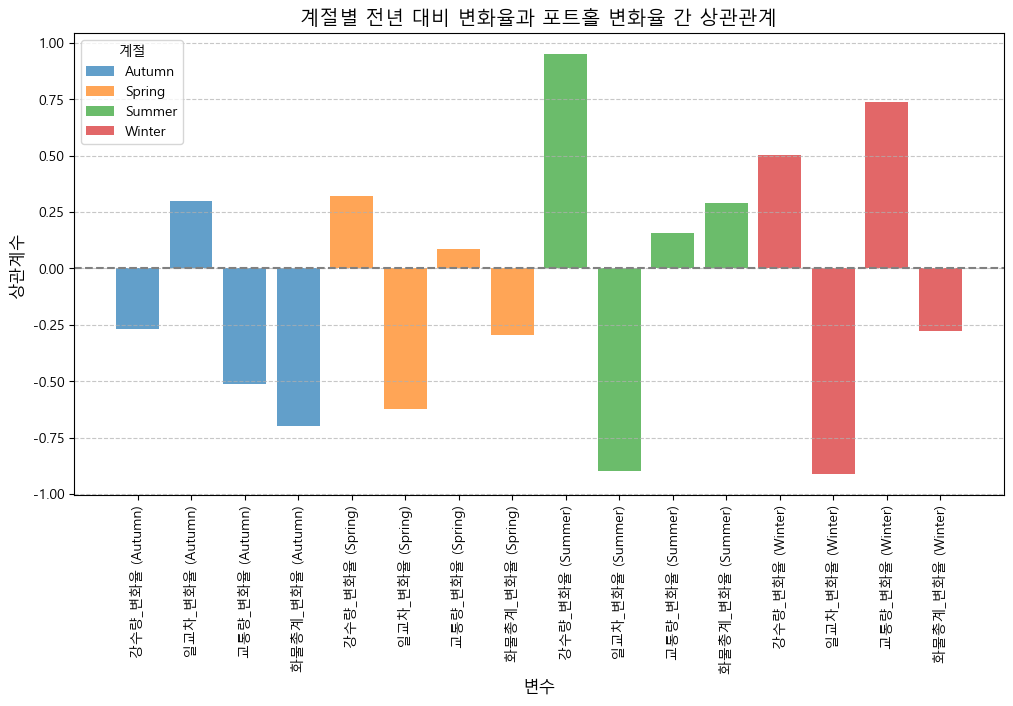

In [15]:
# 계절 정보를 추가
potholes_data['계절'] = potholes_data['발견일자'].apply(assign_season)
rainfall_data['계절'] = rainfall_data['날짜'].apply(assign_season)
temperature_data['계절'] = temperature_data['날짜'].apply(assign_season)
traffic_data['계절'] = traffic_data['날짜'].apply(assign_season)
vehicle_data['계절'] = vehicle_data['날짜'].apply(assign_season)

# 전년 대비 변화를 계산하기 위해 계절별로 데이터 그룹화
seasonal_potholes = potholes_data.groupby(['계절', potholes_data['발견일자'].dt.year]).size().rename('포트홀개수')
seasonal_rainfall = rainfall_data.groupby(['계절', rainfall_data['날짜'].dt.year])['강수량(mm)'].sum()
seasonal_temperature = temperature_data.groupby(['계절', temperature_data['날짜'].dt.year])['일교차'].mean()
seasonal_traffic = traffic_data.groupby(['계절', traffic_data['날짜'].dt.year])['교통량'].mean()
seasonal_vehicles = vehicle_data.groupby(['계절', vehicle_data['날짜'].dt.year])['화물총계'].sum()

# 데이터 통합 (계절별, 연도별)
seasonal_yearly_data = pd.concat(
    [seasonal_potholes, seasonal_rainfall, seasonal_temperature, seasonal_traffic, seasonal_vehicles], axis=1
).dropna()

# 전년 대비 변화율 계산
seasonal_yearly_data_diff = seasonal_yearly_data.groupby('계절').pct_change().dropna()  # 전년 대비 변화율
seasonal_yearly_data_diff.rename(columns={
    '강수량(mm)': '강수량_변화율',
    '일교차': '일교차_변화율',
    '교통량': '교통량_변화율',
    '화물총계': '화물총계_변화율',
    '포트홀개수': '포트홀개수_변화율'
}, inplace=True)

# 상관분석: 계절별 전년 대비 변화율과 포트홀 변화율
correlation_seasonal_yearly = seasonal_yearly_data_diff.groupby('계절').corr().unstack()['포트홀개수_변화율']

# 계절별 상관관계 분석 결과를 시각화
plt.figure(figsize=(12, 6))

# 각 계절별로 상관계수를 시각화
for season in seasonal_yearly_data_diff.index.get_level_values(0).unique():
    subset = correlation_seasonal_yearly.loc[season].drop('포트홀개수_변화율', errors='ignore')
    plt.bar([f"{var} ({season})" for var in subset.index], subset.values, alpha=0.7, label=season)

plt.axhline(0, color='gray', linestyle='--')
plt.title('계절별 전년 대비 변화율과 포트홀 변화율 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.legend(title='계절', fontsize=10)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



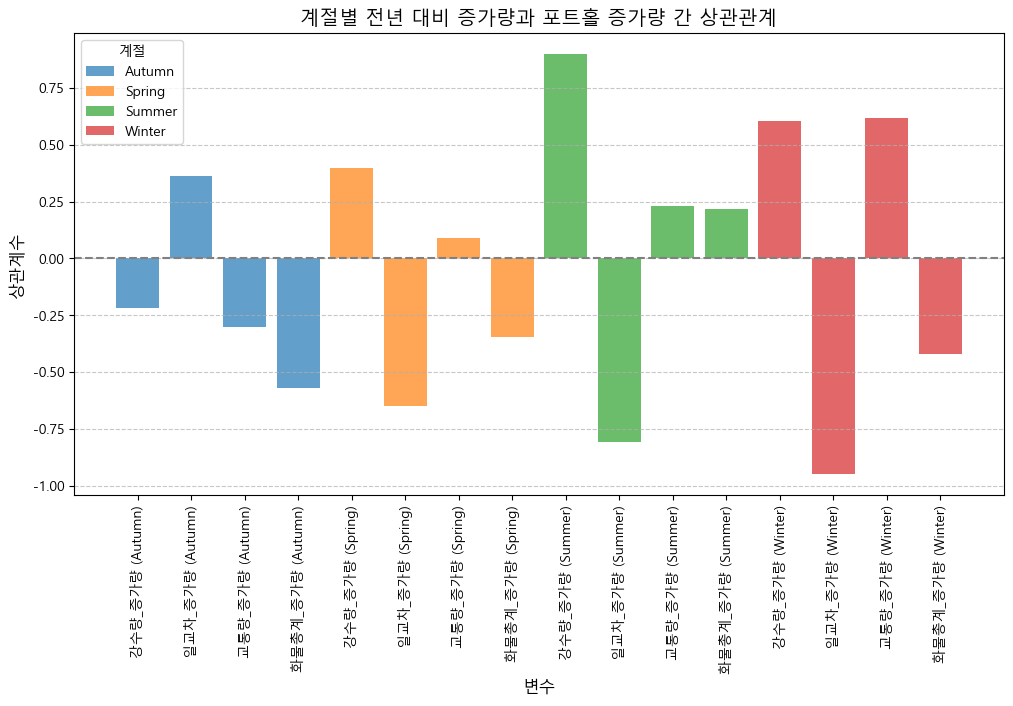

In [16]:
# 계절 정보를 추가
potholes_data['계절'] = potholes_data['발견일자'].apply(assign_season)
rainfall_data['계절'] = rainfall_data['날짜'].apply(assign_season)
temperature_data['계절'] = temperature_data['날짜'].apply(assign_season)
traffic_data['계절'] = traffic_data['날짜'].apply(assign_season)
vehicle_data['계절'] = vehicle_data['날짜'].apply(assign_season)

# 전년 대비 변화를 계산하기 위해 계절별로 데이터 그룹화
seasonal_potholes = potholes_data.groupby(['계절', potholes_data['발견일자'].dt.year]).size().rename('포트홀개수')
seasonal_rainfall = rainfall_data.groupby(['계절', rainfall_data['날짜'].dt.year])['강수량(mm)'].sum()
seasonal_temperature = temperature_data.groupby(['계절', temperature_data['날짜'].dt.year])['일교차'].mean()
seasonal_traffic = traffic_data.groupby(['계절', traffic_data['날짜'].dt.year])['교통량'].mean()
seasonal_vehicles = vehicle_data.groupby(['계절', vehicle_data['날짜'].dt.year])['화물총계'].sum()

# 데이터 통합 (계절별, 연도별)
seasonal_yearly_data = pd.concat(
    [seasonal_potholes, seasonal_rainfall, seasonal_temperature, seasonal_traffic, seasonal_vehicles], axis=1
).dropna()

# 전년 대비 증가율 계산
seasonal_yearly_data_diff = seasonal_yearly_data.groupby('계절').diff().dropna()  # 전년 대비 증가량
seasonal_yearly_data_diff.rename(columns={
    '강수량(mm)': '강수량_증가량',
    '일교차': '일교차_증가량',
    '교통량': '교통량_증가량',
    '화물총계': '화물총계_증가량',
    '포트홀개수': '포트홀개수_증가량'
}, inplace=True)

# 상관분석: 계절별 전년 대비 증가량과 포트홀 증가량
correlation_seasonal_yearly = seasonal_yearly_data_diff.groupby('계절').corr().unstack()['포트홀개수_증가량']

# 계절별 상관관계 분석 결과를 시각화
plt.figure(figsize=(12, 6))

# 각 계절별로 상관계수를 시각화
for season in seasonal_yearly_data_diff.index.get_level_values(0).unique():
    subset = correlation_seasonal_yearly.loc[season].drop('포트홀개수_증가량', errors='ignore')
    plt.bar([f"{var} ({season})" for var in subset.index], subset.values, alpha=0.7, label=season)

plt.axhline(0, color='gray', linestyle='--')
plt.title('계절별 전년 대비 증가량과 포트홀 증가량 간 상관관계', fontsize=14)
plt.xlabel('변수', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.legend(title='계절', fontsize=10)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
